# Exploring LeafSnap Dataset

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### Create a DataFrame

In [54]:
df = pd.read_csv('leafsnap-dataset-images.txt', sep='\t')
df.head()
species_counts = df['species'].value_counts()
# print(species_counts.head(10))


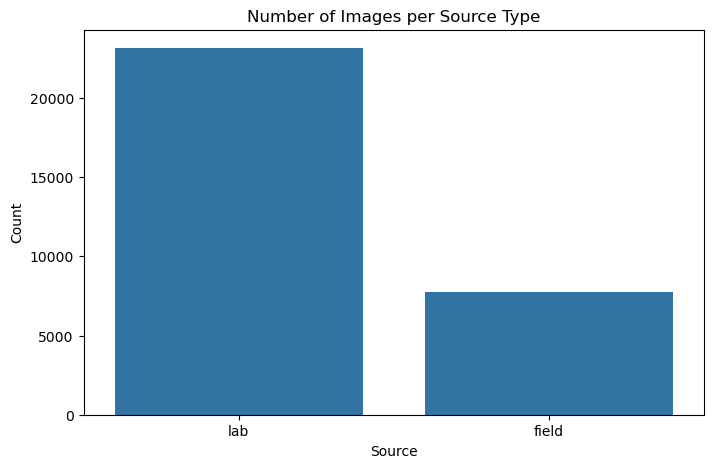

In [55]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='source')
plt.title('Number of Images per Source Type')
plt.xlabel('Source')
plt.ylabel('Count')
plt.show()

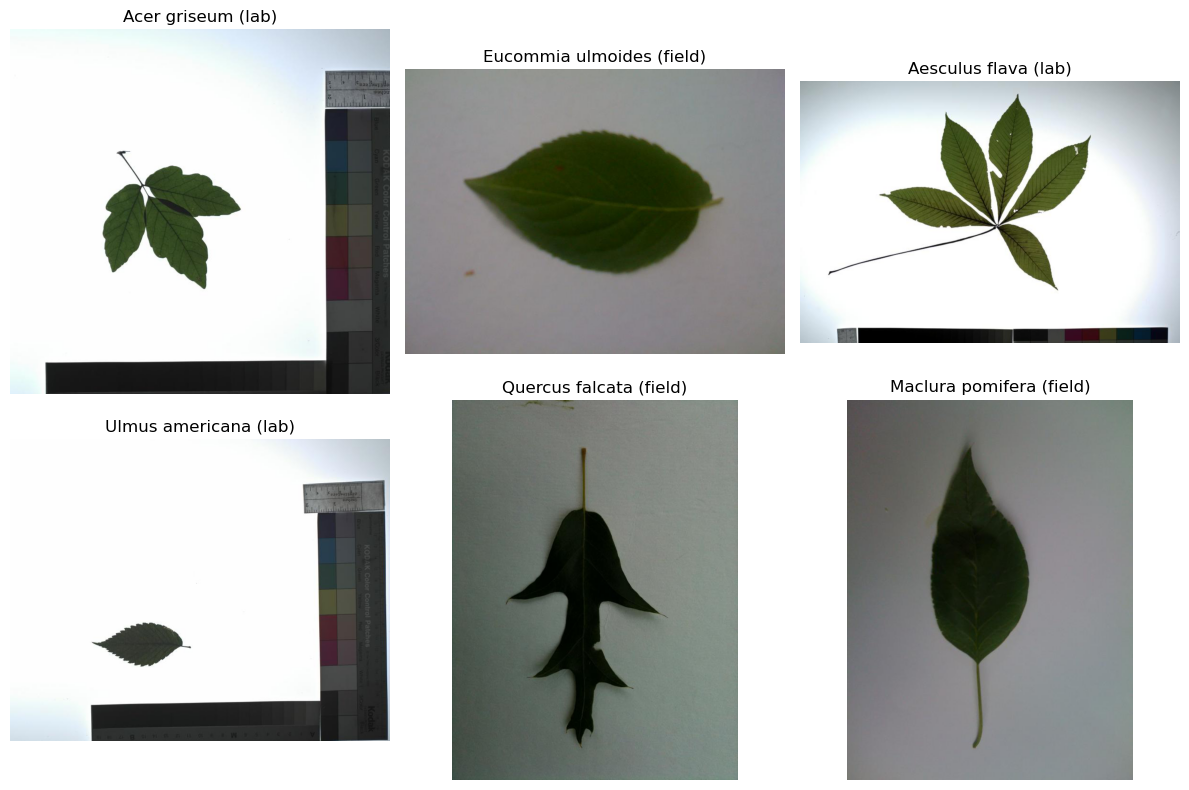

In [56]:

sample = df.sample(6)

plt.figure(figsize=(12, 8))
for i, (_, row) in enumerate(sample.iterrows()):
    img = Image.open(row['image_path'])
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"{row['species']} ({row['source']})")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Number of images per species Histogram

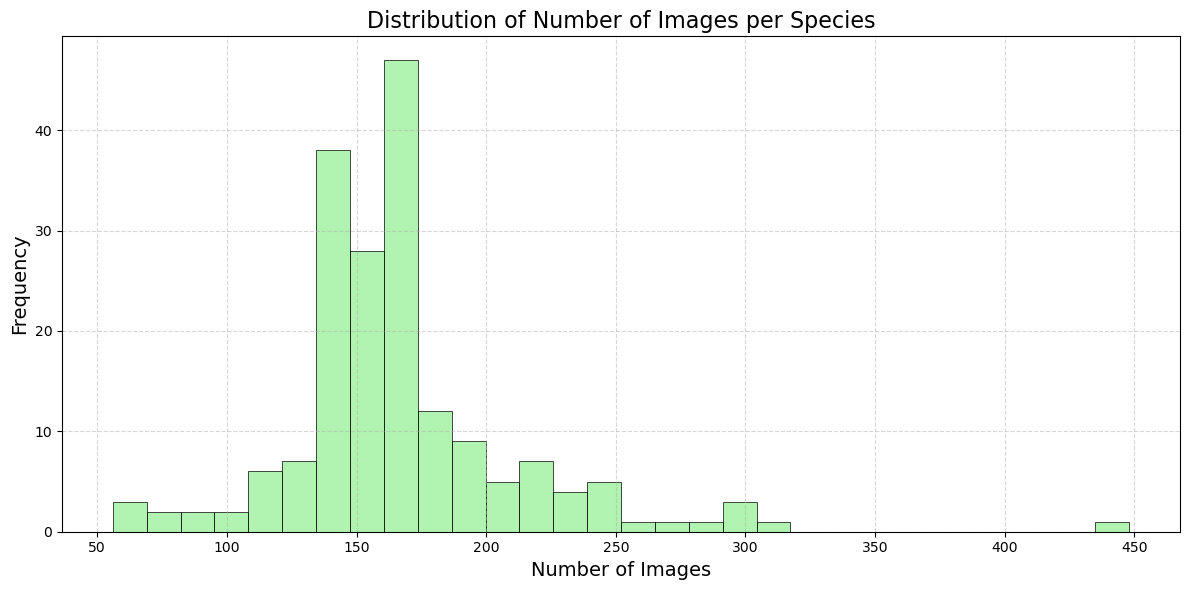

In [57]:
plt.figure(figsize=(12, 6))
sns.histplot(species_counts, bins=30, alpha=0.7, linewidth=0.5, color='lightgreen')
species_counts_df = pd.DataFrame(species_counts).reset_index()
species_counts_df.columns = ['species', 'image_count']
species_counts_df = species_counts_df.sort_values(by='image_count', ascending=False)

plt.title('Distribution of Number of Images per Species', fontsize=16)
plt.xlabel('Number of Images', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Determining what is a "mostly black" image

In [58]:
def black_to_nonblack_ratio(file_path, threshold=15):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, (512, 512))
        img_np = img.numpy()

        black_pixels = np.sum(img_np < threshold)
        non_black_pixels = np.sum(img_np >= threshold)

        print(f"black to white ratio: {non_black_pixels / (black_pixels )}")
        if non_black_pixels == 0:
            return float('inf')
        else:
            return black_pixels / non_black_pixels
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None
    
print("black to nonblack ratio (only scale):")
black_to_nonblack_ratio("dataset/segmented/lab/acer_ginnala/ny1148-03-3.png", 15) 
black_to_nonblack_ratio("dataset/segmented/lab/acer_ginnala/ny1148-10-3.png", 15) 
print("\nblack to nonblack ratio (only leaf):")
black_to_nonblack_ratio("dataset/segmented/lab/acer_ginnala/ny1148-09-1.png", 15)



black to nonblack ratio (only scale):
black to white ratio: 0.034363840827036515
black to white ratio: 0.03406190707233274

black to nonblack ratio (only leaf):
black to white ratio: 0.04867667296060422


20.54372123602893

## Creating a new Dataset
### Using only species with the top 10 most images and have <10% "mostly black" images

In [59]:
def is_mostly_black(file_path, threshold=15, black_ratio=0.95):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, (512, 512))
        img_np = img.numpy()
        black_pixels = np.sum(img_np < threshold)
        total_pixels = img_np.size
        ratio = black_pixels / total_pixels
        return ratio >= black_ratio
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return False

def clean_and_export_dataset(df, output_path='cleaned_dataset.txt'):
    species_black_ratios = {}

    print("Checking images for mostly black pixels...")
    for species in tqdm(df['species'].unique()):
        species_df = df[df['species'] == species]
        black_count = 0

        for path in species_df['segmented_path']:
            if is_mostly_black(path):
                black_count += 1

        total = len(species_df)
        black_ratio = black_count / total
        species_black_ratios[species] = black_ratio

    allowed_species = [species for species, ratio in species_black_ratios.items() if ratio < 0.1]
    df_cleaned = df[df['species'].isin(allowed_species)][['species', 'segmented_path']].reset_index(drop=True)

    df_cleaned.to_csv(output_path, sep='\t', index=False)
    print(f"Saved cleaned dataset with {len(df_cleaned)} images and {len(df_cleaned['species'].unique())} species to '{output_path}'")

    return df_cleaned


df = pd.read_csv("leafsnap-dataset-images.txt", sep='\t')
cleaned_df = clean_and_export_dataset(df)

Checking images for mostly black pixels...


100%|██████████| 185/185 [00:52<00:00,  3.53it/s]

Saved cleaned dataset with 2619 images and 18 species to 'cleaned_dataset.txt'


### Examples of top 3 species

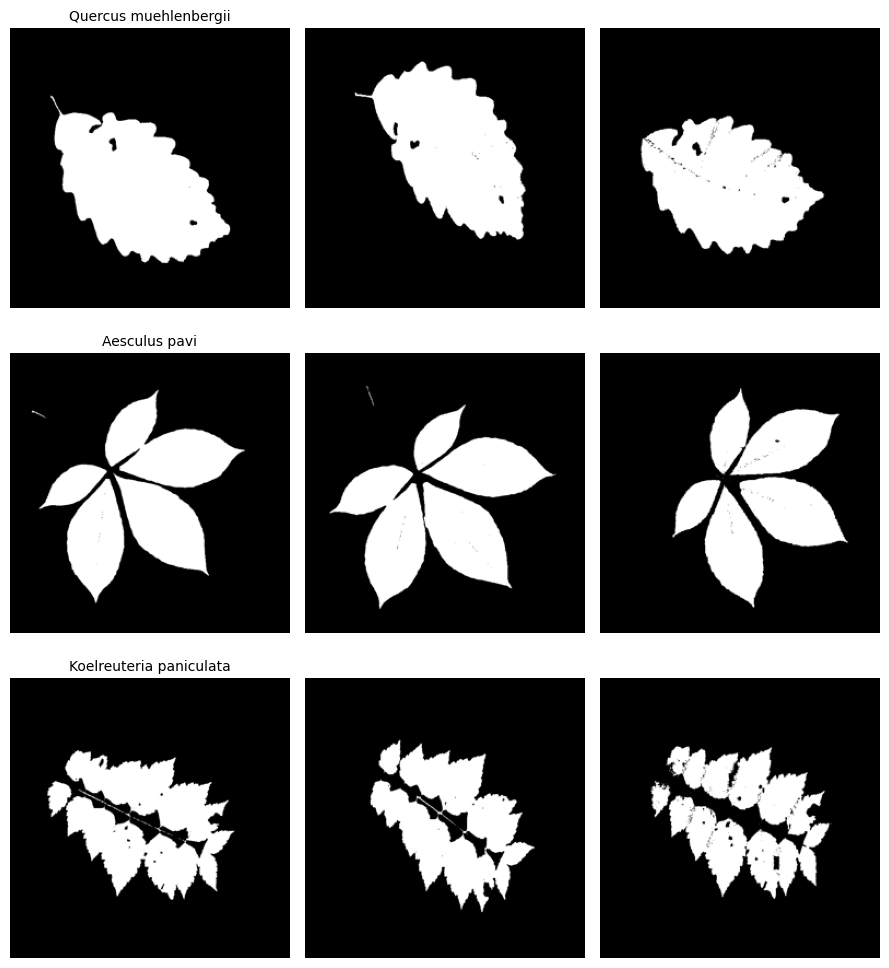

In [60]:
df = pd.read_csv('cleaned_dataset.txt', sep='\t') 


top_species = df['species'].value_counts().nlargest(3).index.tolist()
df_top = df[df['species'].isin(top_species)]

examples = df_top.groupby('species').head(3)
fig, axes = plt.subplots(3, 3, figsize=(9, 10))

for i, species in enumerate(top_species):
    species_examples = examples[examples['species'] == species]
    for j, (_, row) in enumerate(species_examples.iterrows()):
        img_path = row['segmented_path']
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB').resize((256, 256))
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(species, fontsize=10)

plt.tight_layout()
plt.show()


## Preprocessing
### Constants

In [89]:
# Tuning Options
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
EPOCHS = 20

### Image Resizing

In [90]:
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    return img / 255.0


### Encode and Split

In [91]:
def encode_and_split(df):
    image_paths = df['segmented_path'].tolist()
    labels = df['species'].tolist()

    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)

    X_train, X_test, y_train, y_test = train_test_split(
        image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42
    )
    return X_train, X_test, y_train, y_test, label_encoder

### Create Tensorflow Datasets

In [92]:
def create_tf_datasets(X_train, X_test, y_train, y_test):
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_ds = train_ds.map(lambda x, y: (preprocess_image(x), y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_ds = test_ds.map(lambda x, y: (preprocess_image(x), y)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_ds, test_ds

### Fully Prepare Data
- Runs above functions in correct order to preprocess the data

In [93]:
def prepare_leafsnap_data(path='cleaned_dataset.txt'):
    df = pd.read_csv(path, sep='\t') 
    X_train, X_test, y_train, y_test, label_encoder = encode_and_split(df)
    train_ds, test_ds = create_tf_datasets(X_train, X_test, y_train, y_test)
    return train_ds, test_ds, label_encoder

train_ds, test_ds, label_encoder = prepare_leafsnap_data()

### Create CNN

In [94]:

basic_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(*IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])

basic_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# basic_model.summary()


### Training Montage

In [95]:
start_time = time.time()
history = basic_model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS)
end_time = time.time()
seconds = end_time - start_time
minutes = seconds / 60
print(f"Training completed in {seconds:.2f} seconds or {minutes} minutes")
# print accuracy
print(f"Training accuracy: {history.history['accuracy'][-1]} Validation accuracy: {history.history['val_accuracy'][-1]}")

Epoch 1/20


2025-05-01 09:54:32.083443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [2095]
	 [[{{node Placeholder/_1}}]]


131/131 [==============================] - ETA: 0s - loss: 1.7815 - accuracy: 0.4401

2025-05-01 09:54:41.077469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [524]
	 [[{{node Placeholder/_1}}]]


131/131 [==============================] - 10s 71ms/step - loss: 1.7815 - accuracy: 0.4401 - val_loss: 1.3837 - val_accuracy: 0.5744
Epoch 2/20
131/131 [==============================] - 9s 71ms/step - loss: 0.7821 - accuracy: 0.7499 - val_loss: 1.2753 - val_accuracy: 0.6489
Epoch 3/20
131/131 [==============================] - 9s 70ms/step - loss: 0.3962 - accuracy: 0.8721 - val_loss: 1.3345 - val_accuracy: 0.6927
Epoch 4/20
131/131 [==============================] - 9s 71ms/step - loss: 0.2437 - accuracy: 0.9255 - val_loss: 1.8512 - val_accuracy: 0.6279
Epoch 5/20
131/131 [==============================] - 9s 71ms/step - loss: 0.1868 - accuracy: 0.9413 - val_loss: 1.6661 - val_accuracy: 0.7195
Epoch 6/20
131/131 [==============================] - 9s 72ms/step - loss: 0.0866 - accuracy: 0.9709 - val_loss: 1.6195 - val_accuracy: 0.7061
Epoch 7/20
131/131 [==============================] - 9s 72ms/step - loss: 0.0767 - accuracy: 0.9766 - val_loss: 1.6401 - val_accuracy: 0.7099
Epoch 8/2

## Evaluation
### Training and Validation Accuracy

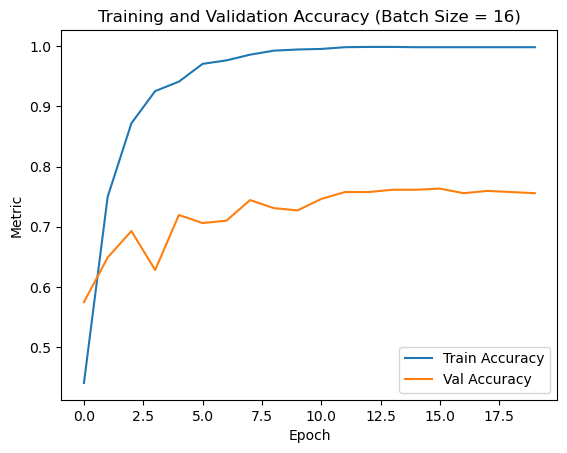

In [96]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('Training and Validation Accuracy (Batch Size = 16)')
plt.savefig("figures/AccuracyBatch16.png", dpi=300)

### Confusion Matrix

33/33 [==============================] - 1s 22ms/step


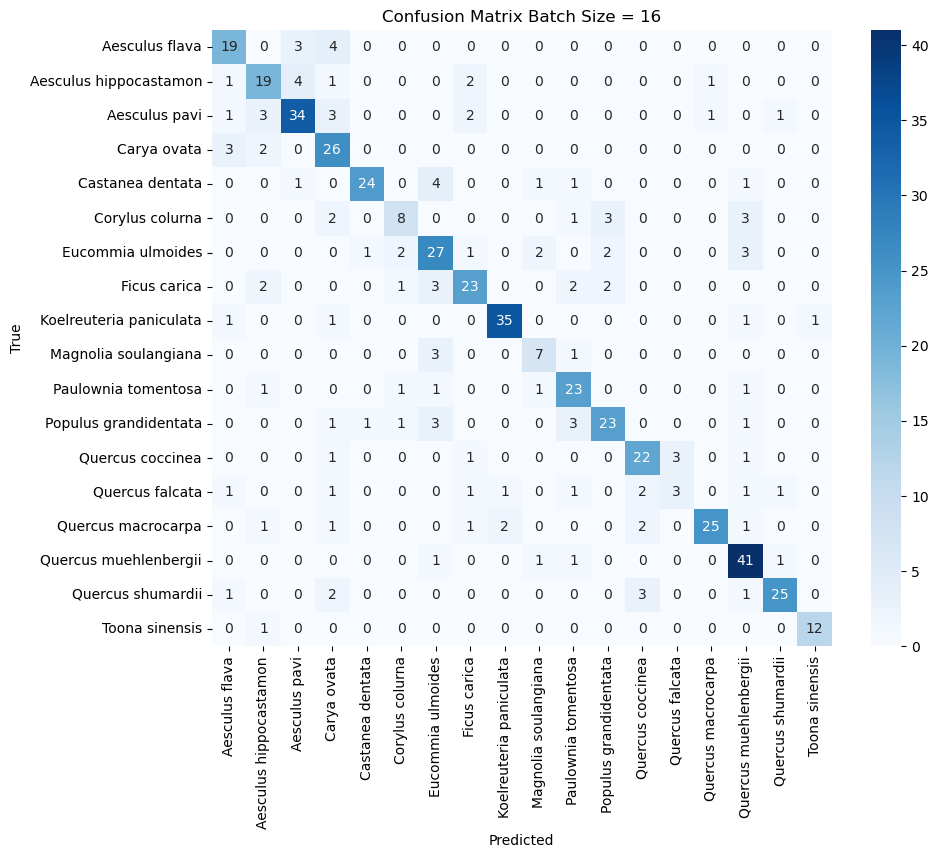

<Figure size 640x480 with 0 Axes>

In [98]:
def plot_confusion_matrix(y_true, y_pred, label_encoder):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Batch Size = 16')
    plt.show()
y_pred = np.argmax(basic_model.predict(test_ds), axis=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)
plot_confusion_matrix(y_true, y_pred, label_encoder)
plt.savefig("figures/ConfusionMatrixBatch16.png", dpi=300)

## MobileNetV2 (Transfer Learning)
- Model too complex for BW images (overfitting)
### Separate top 10 species with most images (color)

,file_id,image_path,segmented_path,species,source
0,55497,dataset/images/lab/abies_concolor/ny1157-01-1.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
1,55498,dataset/images/lab/abies_concolor/ny1157-01-2.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
2,55499,dataset/images/lab/abies_concolor/ny1157-01-3.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
3,55500,dataset/images/lab/abies_concolor/ny1157-01-4.jpg,dataset/segmented/lab/abies_concolor/ny1157-01...,Abies concolor,lab
4,55501,dataset/images/lab/abies_concolor/ny1157-02-1.jpg,dataset/segmented/lab/abies_concolor/ny1157-02...,Abies concolor,lab
...,...,...,...,...,...
30812,75720,dataset/images/lab/ulmus_rubra/wb1219-09-4.jpg,dataset/segmented/lab/ulmus_rubra/wb1219-09-4.png,Ulmus rubra,lab
30813,75721,dataset/images/lab/ulmus_rubra/wb1219-10-1.jpg,dataset/segmented/lab/ulmus_rubra/wb1219-10-1.png,Ulmus rubra,lab
30814,75722,dataset/images/lab/ulmus_rubra/wb1219-10-2.jpg,dataset/segmented/lab/ulmus_rubra/wb1219-10-2.png,Ulmus rubra,lab
30815,75723,dataset/images/lab/ulmus_rubra/wb1219-10-3.jpg,dataset/segmented/lab/ulmus_rubra/wb1219-10-3.png,Ulmus rubra,lab


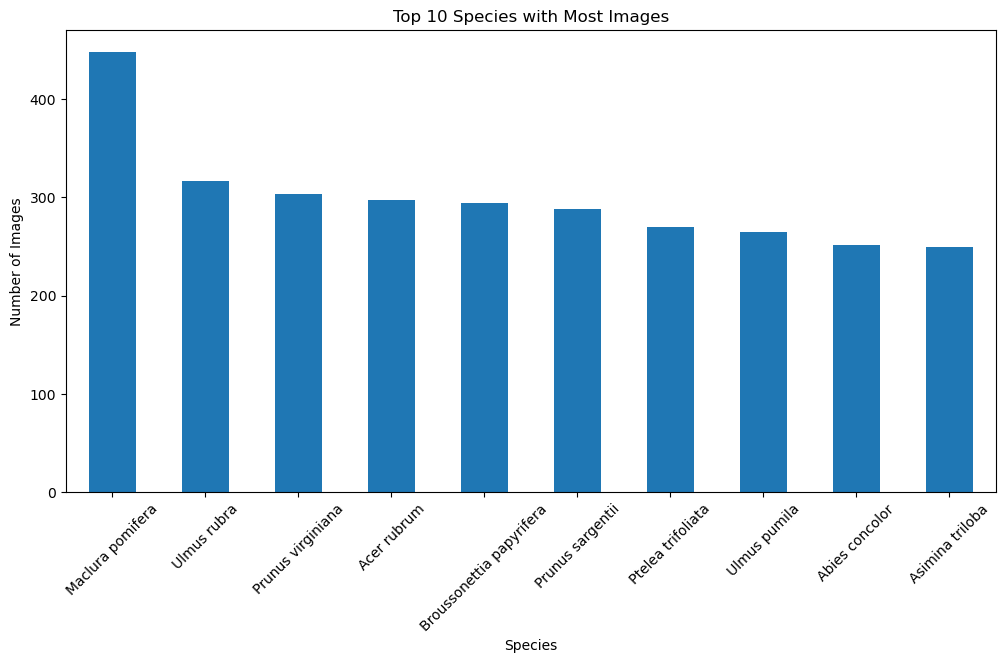

In [102]:
df = pd.read_csv('leafsnap-dataset-images.txt', sep='\t')
# get rid of all species except the top 10 with most images
top_species = df['species'].value_counts().nlargest(10).index.tolist()
df_top = df[df['species'].isin(top_species)]
df_top['species'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Species with Most Images')
plt.xlabel('Species')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.savefig("figures/Top10Species.png", dpi=300)

# create a new df with only image_paths that have 'lab' as their source and species in top_species
df_top_lab = df_top[df_top['source'] == 'lab']
# save the new df to a file
df_top_lab.to_csv('leafsnap-top10-lab.txt', sep='\t', index=False)
# check the new df
display(df_top_lab)


Epoch 1/20


2025-05-01 10:56:07.556250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype resource
	 [[{{node Placeholder/_6}}]]
2025-05-01 10:56:07.556454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype resource
	 [[{{node Placeholder/_7}}]]


54/55 [============================>.] - ETA: 0s - loss: 1.4021 - accuracy: 0.5359

2025-05-01 10:56:19.203065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int8 and shape [433]
	 [[{{node Placeholder/_1}}]]
2025-05-01 10:56:19.203196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int8 and shape [433]
	 [[{{node Placeholder/_1}}]]


55/55 [==============================] - 14s 224ms/step - loss: 1.4006 - accuracy: 0.5367 - val_loss: 0.6473 - val_accuracy: 0.7945 - lr: 0.0010
Epoch 2/20
55/55 [==============================] - 13s 216ms/step - loss: 0.5111 - accuracy: 0.8631 - val_loss: 0.3283 - val_accuracy: 0.9330 - lr: 0.0010
Epoch 3/20
55/55 [==============================] - 13s 216ms/step - loss: 0.3174 - accuracy: 0.9214 - val_loss: 0.2251 - val_accuracy: 0.9607 - lr: 0.0010
Epoch 4/20
55/55 [==============================] - 13s 217ms/step - loss: 0.2317 - accuracy: 0.9451 - val_loss: 0.1812 - val_accuracy: 0.9654 - lr: 0.0010
Epoch 5/20
55/55 [==============================] - 13s 221ms/step - loss: 0.1766 - accuracy: 0.9648 - val_loss: 0.1560 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 6/20
55/55 [==============================] - 13s 218ms/step - loss: 0.1461 - accuracy: 0.9700 - val_loss: 0.1412 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 7/20
55/55 [==============================] - 18s 302ms/step - loss: 

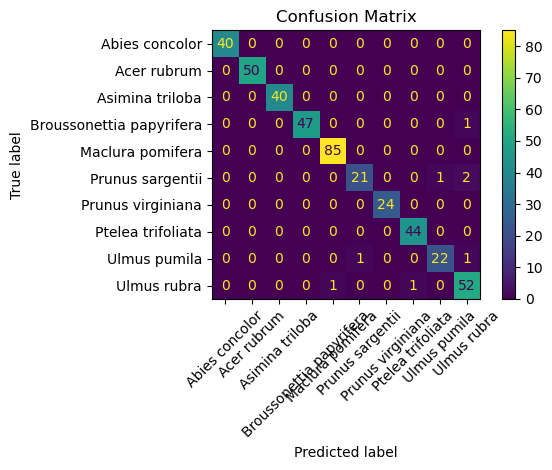

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIG ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 20

# --- LOAD DATA ---
df = pd.read_csv("leafsnap-top10-lab.txt", sep="\t")
image_paths = df["image_path"].values
labels = df["species"].astype('category').cat.codes.values
class_names = df["species"].astype('category').cat.categories.tolist()
num_classes = len(class_names)

# --- SPLIT ---
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# --- IMAGE LOADING FUNCTION ---
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

# --- DATASETS ---
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

train_ds = train_ds.map(load_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_image, num_parallel_calls=AUTOTUNE)

# --- AUGMENTATION (training only) ---
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05)
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

# --- BATCH & PREFETCH ---
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# --- MODEL ---
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze for now

model = models.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# --- CALLBACKS ---
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# --- TRAIN ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

### Evaluation

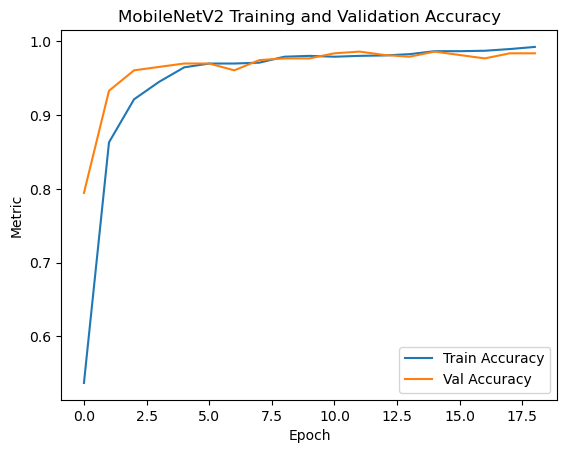

In [108]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.legend()
plt.title('MobileNetV2 Training and Validation Accuracy')
plt.savefig("figures/MobileNetV2Training.png", dpi=300)

### Confusion Matrix

In [ ]:
y_pred = np.argmax(mobileNet_model.predict(test_ds), axis=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)
plot_confusion_matrix(y_true, y_pred, label_encoder)